In [ ]:
!pip install census

In [ ]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census

# Census API Key
from config import api_key
#c = Census(api_key, year=2016)

In [ ]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
def get_census(year):
    c = Census(api_key, year=year)
    census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E"), 
                         {'for': 'county:*'})
                        # {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

# Column Reordering
    census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "NAME": "Name", "county": "County"
                                      })

# Add in Poverty Rate (Poverty Count / Population)
    census_pd["Poverty Rate"] = 100 * \
        census_pd["Poverty Count"].astype(
            int) / census_pd["Population"].astype(int)

# Final DataFrame
    census_pd = census_pd[["Name","County", "Population", "Median Age", "Household Income",
                           "Per Capita Income", "Poverty Count", "Poverty Rate"]]

    census_pd['county_name'] = census_pd['Name'].str.replace(r" County,(.*)",'').str.upper()
    census_pd['state'] = census_pd['Name'].str.replace(r"(.*) County, ",'').str.upper()
# Visualize
    
    return census_pd

census_2012 = get_census(2012)
census_2012.head()
census_2012['year'] = 2012

census_2016 = get_census(2016)
census_2016.head()
census_2016['year'] = 2016

census_2020 = get_census(2020)
census_2020['year'] = 2020
census_2020.head()
census = pd.concat([census_2012,census_2016,census_2020])


In [ ]:
census.dtypes

In [ ]:
census = census[census['Household Income']>0]
census

In [ ]:
census.to_csv("clean_census.csv", encoding="utf-8", index=False)

In [ ]:
# # Save as a csv
# # Note to avoid any issues later, use encoding="utf-8"
winners_pd=pd.read_csv("countypres_2000-2020_with_winner.csv")
# winners_pd = winners_pd[((winners_pd['year'] == 2016) | (winners_pd['year'] == 2020)) & (winners_pd['state']== 'GEORGIA') & (winners_pd['county_name']== "WORTH")]
winners_pd

In [ ]:
# dem_pd = winners_pd[winners_pd['party'] == 'DEMOCRAT']
# dem_pd
#  #& ((winners_pd['party'] == 'DEMOCRAT') | (winners_pd['party'] == 'REPUBLICAN') )


In [ ]:
# rep_pd = winners_pd[winners_pd['party'] == 'REPUBLICAN']
# rep_pd


In [ ]:
# merge_pd=dem_pd.merge(rep_pd, on = ['year','state', 'county_name'])
# merge_pd.head(100)

In [ ]:
# merge_pd['winner'] = np.where(merge_pd['candidatevotes_x'] > merge_pd['candidatevotes_y'], merge_pd['party_x'], merge_pd['party_y'])
# merge_pd = merge_pd[['year','state','county_name','winner']]
# merge_pd

In [ ]:
#Dave's code
winners_pd = winners_pd[((winners_pd['year'] == 2012) | (winners_pd['year'] == 2016) | (winners_pd['year'] == 2020))]
winners_pd = winners_pd[((winners_pd['party'] == 'DEMOCRAT') | (winners_pd['party'] == 'REPUBLICAN'))]
#winners_pd = winners_pd[((winners_pd['state']== 'GEORGIA') & (winners_pd['county_name']== "WORTH"))]
#winners_pd.head(100)
winners_pd=winners_pd.drop_duplicates(subset=['state_po','county_name', 'year'],keep='first')

In [ ]:
winners_pd

In [ ]:
cleaned_census_data = pd.merge(census, winners_pd, how='left', left_on=['year','state', 'county_name'], right_on=['year','state', 'county_name'])

cleaned_census_data = cleaned_census_data[['year','state','state_po','county_name','Population','Median Age', 'Household Income', 'Per Capita Income', 'Poverty Rate', 'Winner']]
cleaned_census_data

In [ ]:
cleaned_census_data.dropna(subset =["state_po"],inplace=True)
# cleaned_census_data.drop_duplicates()
# cleaned_census_data

In [ ]:
#cleaned_census_data.dropna(inplace=True)

In [ ]:
cleaned_census_data.groupby('year').sum()

In [ ]:
cleaned_census_data.to_csv("clean_data.csv", encoding="utf-8", index=False)

Random Forest Model

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('clean_data.csv')

In [3]:
df.dtypes

year                   int64
state                 object
state_po              object
county_name           object
Population             int64
Median Age           float64
Household Income       int64
Per Capita Income      int64
Poverty Rate         float64
Winner                object
dtype: object

In [ ]:
# for col in df.columns:
#     if df[col].dtype == 'object':
#         df[col] = pd.to_numeric(df[col], errors='coerce')

In [8]:
df = df.drop(columns=['state', 'county_name','state_po'])

In [ ]:
#pd.get_dummies(X['state_po'])

In [9]:
df.dtypes

year                   int64
Population             int64
Median Age           float64
Household Income       int64
Per Capita Income      int64
Poverty Rate         float64
Winner                object
dtype: object

In [10]:
#df.dropna(inplace=True)
        
X = df.drop('Winner', axis=1)
y = df['Winner']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#np.seterr(divide='ignore', invalid='ignore')

In [12]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.855715871254162


[0.02810507 0.29913808 0.150774   0.15634069 0.18382481 0.18181734]


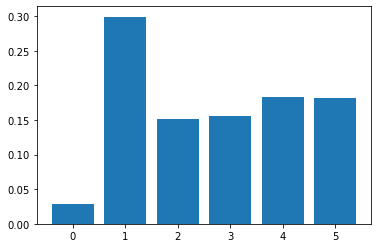

In [13]:
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

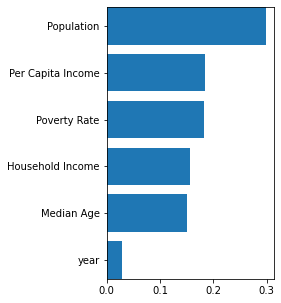

In [26]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(3,5)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [27]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)
sel.get_support()

ValueError: Found input variables with inconsistent numbers of samples: [8106, 6755]

In [25]:
X.shape
y.shape

(9007,)

In [28]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\nico.cosereanu\Anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: when `importance_getter=='auto'`, the underlying estimator RandomForestClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [29]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

ValueError: Found input variables with inconsistent numbers of samples: [8106, 6755]